# User defined equations of state

In this notebook, we will give an example of how to implement a new equation of state within `Clapeyron.jl`. In this case, it will be the SAFT-VR Mie+AT model developed by Walker _et al._ which is simply a modification of the regular SAFT-VR Mie equation of state. 

The first step is to call `Clapeyron.jl` as one normally would only this time importing a few additional functions which we would like to modify:

In [1]:
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot
import Clapeyron: SAFTVRMieModel, @f, @newmodel, transform_params, default_locations, default_references, N_A, SingleComp, SA
import Clapeyron: a_res, a_disp, a_hs, d, B, aS_1, KHS, f123456, Cλ, ∑, data, d_vrmie

  Activating project at `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/University/UROP/SAFT_codes/Clapeyron`


The next step is to define the parameter object for our equation of state. This is all the parameters we will need within the equation. The parameter type will also need to be defined (`SingleParam` for those parameters which only depend on a single species and `PairParam` for those which depend on two species):

In [2]:
struct SAFTVRMieATParam <: EoSParam
    segment::SingleParam{Float64}
    sigma::PairParam{Float64}
    lambda_a::PairParam{Float64}
    lambda_r::PairParam{Float64}
    epsilon::PairParam{Float64}
    Mw::SingleParam{Float64}
    nu::SingleParam{Float64}
end

The next step is to define the model type. Since SAFT-VR Mie+AT re-uses many of the same functions as SAFT-VR Mie, we define the `SAFTVRMieATModel` as a sub-type of `SAFTVRMieModel`. This effectively means we only need to re-define those functions which are different between the two equations:

In [3]:
abstract type SAFTVRMieATModel <: SAFTVRMieModel end

We then create the model using the `@newmodel` macro:

In [10]:
@newmodel SAFTVRMieAT SAFTVRMieATModel SAFTVRMieATParam
default_references(::Type{SAFTVRMieAT}) = ["10.1063/1.4819786", "10.1080/00268976.2015.1029027","10.1063/5.0087125"]
default_locations(::Type{SAFTVRMieAT}) = ["properties/molarmass.csv"]

default_locations (generic function with 50 methods)

The next function that needs to be built is the model constructor (here called `SAFTVRMieAT`). This involves a few different components:

In [5]:
# Although optional, there should be some additional argument if the user would like to modify certain aspects of the model, such as the ideal model used
function transform_params(::Type{SAFTVRMieAT},params)
    sigma = params["sigma"]
    sigma.values .*= 1E-10
    sigma = sigma_LorentzBerthelot(sigma)
    epsilon = epsilon_HudsenMcCoubrey(params["epsilon"], sigma)
    lambda_a = lambda_LorentzBerthelot(params["lambda_a"])
    lambda_r = lambda_LorentzBerthelot(params["lambda_r"])
    params["sigma"] = sigma
    params["epsilon"] = epsilon
    params["lambda_a"] = lambda_a
    params["lambda_r"] = lambda_r
    return params
end

transform_params (generic function with 29 methods)

Export the SAFTVRMieAT model

In [6]:
export SAFTVRMieAT

The next step involves writing down the equations used within the equation of state. At the end of the day, the output should be `a_res`, the reduced residual Helmholtz free energy:

In [7]:
function d(model::SAFTVRMieATModel, V, T, z::SingleComp)
    # this function is only defined for single component models.
    
    λ  = 0.85
    ρ  = N_A*sum(z)/V
    # epsilon, signa, lambda_a,lambda_r are pair parameters, but if you
    # call it via param[i] it will return the value (i,i)
    _ϵ = model.params.epsilon
    _σ = model.params.sigma
    _λa = model.params.lambda_a
    _λr = model.params.lambda_r
    _ν  = model.params.nu.values

    σ = _σ[1]
    ν = _ν[1]
    λa = _λa[1]
    λr = _λr[1]
    ϵ = _ϵ[1]*(1-ρ*λ*ν*σ^3)    
    return d_vrmie(T,λa,λr,σ,ϵ)
end

# @f(data) = data(model,V,T,z)
function a_disp(model::SAFTVRMieATModel, V, T, z,_data = @f(data))
    _d,ρS,ζi,_ζ_X,_ζst,_ = _data
    l = length(model) #we query the amount of components of the model.
    ∑z = ∑(z)
    m = model.params.segment
    _ϵ = model.params.epsilon
    _λr = model.params.lambda_r
    _λa = model.params.lambda_a
    _σ = model.params.sigma
    _ν = model.params.nu
    m̄ = Clapeyron.dot(z, m)
    m̄inv = 1/m̄
    a₁ = zero(V+T+first(z)) #a zero of the corresponding type
    a₂ = a₁
    a₃ = a₁
    _ζst5 = _ζst^5
    _ζst8 = _ζst^8
    _KHS = @f(KHS,_ζ_X,ρS) #KHS(model,V,T,z,_ζ_X,ρS)
    
    ρ  = N_A*sum(z)/V
    λ  = 0.85
    for i ∈ 1:l
        j = i
        x_Si = z[i]*m[i]*m̄inv
        x_Sj = x_Si
        ϵ = _ϵ[i,j]
        λa = _λa[i,i]
        λr = _λr[i,i] 
        σ = _σ[i,i]
        ν  = _ν[i]
        AT_corr = (1-ρ*λ*ν*σ^3)
        _C = @f(Cλ,λa,λr)
        dij = _d[i]
        dij3 = dij^3
        x_0ij = σ/dij
        #calculations for a1 - diagonal
        aS_1_a = @f(aS_1,λa,_ζ_X)
        aS_1_r = @f(aS_1,λr,_ζ_X)
        B_a = @f(B,λa,x_0ij,_ζ_X)
        B_r = @f(B,λr,x_0ij,_ζ_X)
        a1_ij = (2*π*AT_corr*ϵ*dij3)*_C*ρS*
        (x_0ij^λa*(aS_1_a+B_a) - x_0ij^λr*(aS_1_r+B_r))

        #calculations for a2 - diagonal
        aS_1_2a = @f(aS_1,2*λa,_ζ_X)
        aS_1_2r = @f(aS_1,2*λr,_ζ_X)
        aS_1_ar = @f(aS_1,λa+λr,_ζ_X)
        B_2a = @f(B,2*λa,x_0ij,_ζ_X)
        B_2r = @f(B,2*λr,x_0ij,_ζ_X)
        B_ar = @f(B,λr+λa,x_0ij,_ζ_X)
        α = _C*(1/(λa-3)-1/(λr-3))
        f1,f2,f3,f4,f5,f6 = @f(f123456,α)
        _χ = f1*_ζst+f2*_ζst5+f3*_ζst8
        a2_ij = π*_KHS*(1+_χ)*ρS*AT_corr^2*ϵ^2*dij3*_C^2 *
        (x_0ij^(2*λa)*(aS_1_2a+B_2a)
        - 2*x_0ij^(λa+λr)*(aS_1_ar+B_ar)
        + x_0ij^(2*λr)*(aS_1_2r+B_2r))
        
        #calculations for a3 - diagonal
        a3_ij = -ϵ^3*AT_corr^3*f4*_ζst * exp(f5*_ζst+f6*_ζst^2)
        #adding - diagonal
        a₁ += a1_ij*x_Si*x_Si
        a₂ += a2_ij*x_Si*x_Si
        a₃ += a3_ij*x_Si*x_Si
    end
    a₁ = a₁*m̄/T/∑z
    a₂ = a₂*m̄/(T*T)/∑z
    a₃ = a₃*m̄/(T*T*T)/∑z
    #@show (a₁,a₂,a₃)
    adisp =  a₁ + a₂ + a₃ 
    return adisp
end

function a_res(model::SAFTVRMieATModel, V, T, z)
    _data = @f(data)
    return @f(a_hs,_data)+@f(a_disp,_data)
end

a_res (generic function with 38 methods)

With that, the equation is built and ready to use! As an example:

In [8]:
species = [["He_JHBV"],["Ne_JHBV"],["Ar_JHBV"],["Kr_JHBV"],["Xe_JHBV"]]

model = SAFTVRMieAT.(species; userlocations=["Ab_initio_SAFT.csv","Ab_initio_SAFT_unlike.csv","Ab_initio_SAFT_assoc.csv"],
                              ideal_userlocations=["Ab_initio_SAFT_molarmass.csv"]);

Dict{String, Clapeyron.ClapeyronParam}("nu" => SingleParam{Float64}("nu")["He_JHBV"], "lambda_r" => PairParam{Float64}("lambda_r")["He_JHBV"], "n_H" => SingleParam{Int64}("n_H")["He_JHBV"], "sigma" => PairParam{Float64}("sigma")["He_JHBV"], "assoc_options" => AssocOptions(1.0e-12, 1.0e-12, 1000, 0.5, :nocombining, true), "lambda_a" => PairParam{Float64}("lambda_a")["He_JHBV"], "bondvol" => AssocParam{Float64}("bondvol")Float64[], "Mw" => SingleParam{Float64}("Mw")["He_JHBV"], "segment" => SingleParam{Float64}("segment")["He_JHBV"], "epsilon" => PairParam{Float64}("epsilon")["He_JHBV"], "n_e" => SingleParam{Int64}("n_e")["He_JHBV"], "sites" => SiteParam["He_JHBV" => []], "epsilon_assoc" => AssocParam{Float64}("epsilon_assoc")Float64[])
Dict{String, Clapeyron.ClapeyronParam}("nu" => SingleParam{Float64}("nu")["Ne_JHBV"], "lambda_r" => PairParam{Float64}("lambda_r")["Ne_JHBV"], "n_H" => SingleParam{Int64}("n_H")["Ne_JHBV"], "sigma" => PairParam{Float64}("sigma")["Ne_JHBV"], "assoc_options

We can then obtain critical and saturation properties, and plot the results:

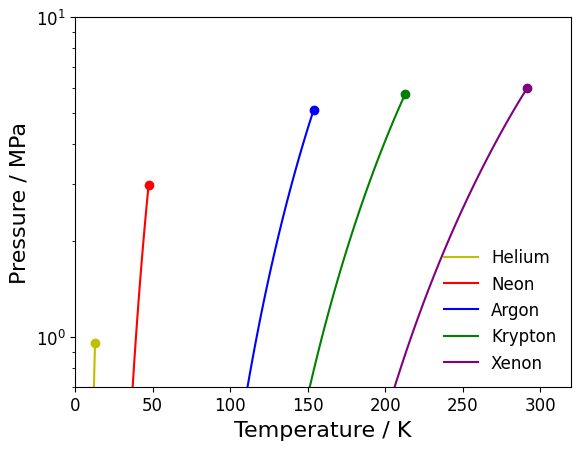

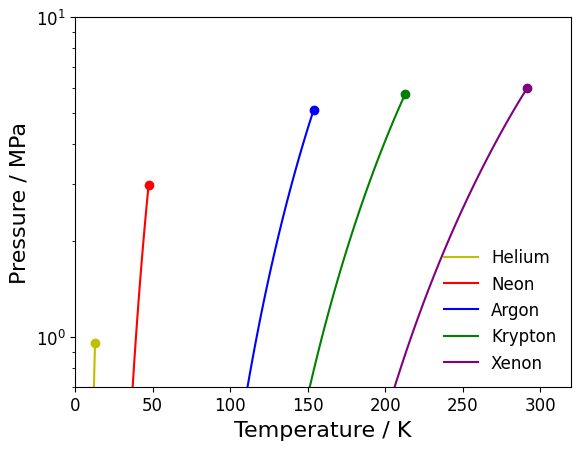

In [9]:
label=["Helium","Neon","Argon","Krypton","Xenon"]
color=["y","r","b","g","purple"]

crit=crit_pure.(model); # a vector of (Tc,Pc,Vc) values

plt.clf()
for i ∈ 1:5
    Tci = crit[i][1]
    T = range(0.7*Tci,Tci,length=100)

    sat = saturation_pressure.(model[i],T) # a vector of (Psat,Vlsat,Vvsat) values

    #reorder the data, to have a vector of P, v_l, v_v
    p = [sat[i][1] for i ∈ 1:100]
    v_l = [sat[i][2] for i ∈ 1:100]
    v_v = [sat[i][3] for i ∈ 1:100]
    plt.semilogy(T,p./1e6,color=color[i],label=label[i])
    plt.plot(crit[i][1],crit[i][2]./1e6,marker="o",color=color[i])
end
plt.ylim([0.7,1e1])
plt.xlim([0,320])
plt.legend(loc="lower right",frameon=false,fontsize=12) 
plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
display(plt.gcf())